In [1]:
from processing_utils import DataPrepare
from gru_training_utils import TimeSeriesDataset, mape
from studu_utils import plot_predictions

import polars as pl
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import math
import random
import copy
import torch.optim as optim


In [2]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\dfs\2024-06-29 20-00-00_2024-07-01 00-00-00_delta_0-00-10_return_5_sec.parquet')
target_var: str = "log_return"
cat_features = ['currency_pair']

In [3]:
data = DataPrepare(df)

In [4]:
df_train, df_test = data.train_test_split()

Train test ratio is 0.8
Train len for DOGEUSDT is 7616
Test len for DOGEUSDT is 1904
Train len for AVAXUSDT is 6586
Test len for AVAXUSDT is 1647


smooth
[nan nan nan ... nan nan nan]


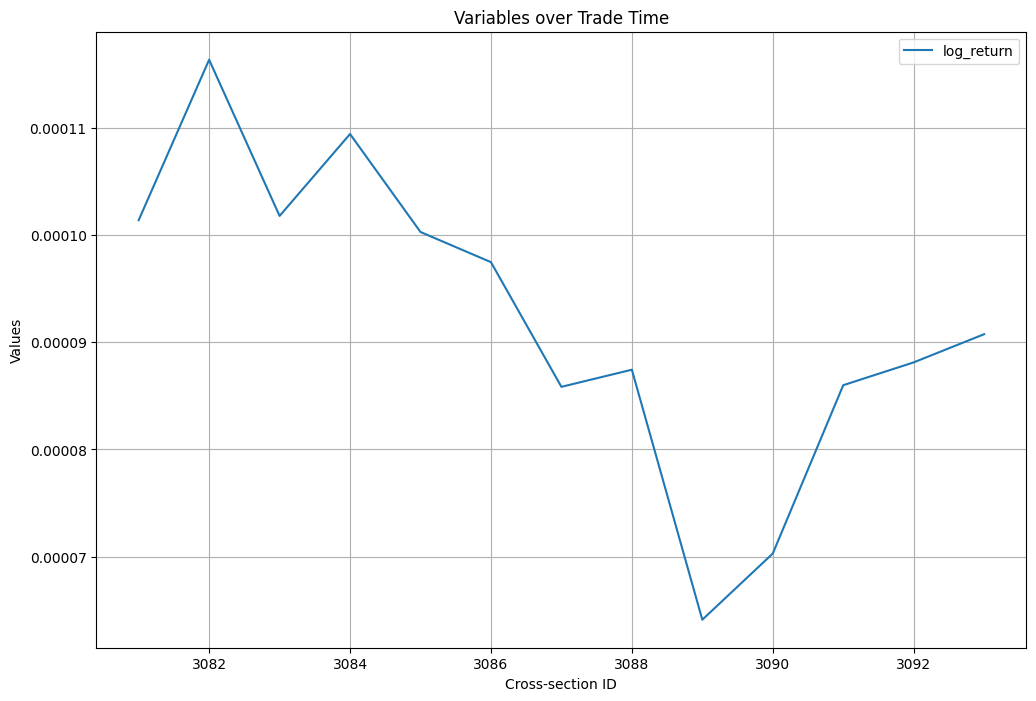

In [7]:
check = DataPrepare(df_train)
check.visualize(start_time=datetime(2024, 6, 28), end_time=datetime(2024, 7, 2), variables_to_plot=["log_return"])


In [28]:
class GRUModel(nn.Module):
    def __init__(self, input_features: int, num_currency_pairs: int,
                 hidden_size: int, num_layers: int, dropout: float):
        """
        input_features: number of features per currency pair
        num_currency_pairs: how many currency pairs we have
        hidden_size: number of units in GRU hidden layer(s)
        num_layers: number of stacked GRU layers
        dropout: dropout rate between GRU layers (if num_layers > 1)
        """
        super(GRUModel, self).__init__()
        self.num_currency_pairs = num_currency_pairs
        self.input_features = input_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Input size to GRU = input_features * num_currency_pairs
        input_size = input_features * num_currency_pairs

        # Define GRU
        # batch_first=True means input is (batch, seq_len, input_size)
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        # Final fully connected layer to map hidden state to num_currency_pairs predictions
        self.fc = nn.Linear(hidden_size, num_currency_pairs)

    def forward(self, X, h=None):
        # X shape: (batch, seq_length, features, currency_pairs)
        B, F, C, L = X.shape
        #[32, 11, 2, 10]
        # From (B, F, C, L) to (B, L, F, C)
        X = X.permute(0, 3, 1, 2)  # 0->0, 3->1, 1->2, 2->3
        # Now X is (32, 10, 11, 2), which means:
        # B=32, L=10, F=11, C=2
        
        X = X.reshape(B, L, F*C)   # (32, 10, 22)
        # Pass through GRU
        # out: (B, L, hidden_size)
        # If h is provided, use it as initial hidden state
        out, h_n = self.gru(X, h)  # out: (B, L, hidden_size)
        last_out = out[:, -1, :]   # (B, hidden_size)
        preds = self.fc(last_out)  # (B, num_currency_pairs)
        return preds, h_n


In [29]:
def train_model(
    train_dataset,
    test_dataset,
    input_features,
    num_currency_pairs,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    initial_lr=1e-4,
    min_lr=1e-5,
    factor=0.5,
    patience=10, # patience for scheduler and early stopping
    batch_size=32,
    num_epochs=50,
    log_dir="./logs",
):
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    model = GRUModel(input_features, num_currency_pairs, hidden_size, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, min_lr=min_lr)

    writer = SummaryWriter(log_dir=log_dir)

    # Hyperparameters dict for TensorBoard
    hparams = {
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout,
        "initial_lr": initial_lr,
        "min_lr": min_lr,
        "factor": factor,
        "patience": patience,
        "batch_size": batch_size,
        "num_epochs": num_epochs
    }

    global_step = 0
    best_val_rmse = float("inf")
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        h = None
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds, h = model(X_batch, h)
            h = h.detach()

            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            writer.add_scalar("Train/MSE", loss.item(), global_step)
            global_step += 1

        avg_train_mse = train_loss / len(train_loader)
        avg_train_rmse = math.sqrt(avg_train_mse)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_steps = 0
        all_preds = []
        all_targets = []

        # Continue from training hidden state for validation
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds, h = model(X_batch, h)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()

                all_preds.append(preds)
                all_targets.append(y_batch)
                val_steps += 1

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        avg_val_mse = val_loss / val_steps
        avg_val_rmse = math.sqrt(avg_val_mse)
        current_mape = mape(all_preds, all_targets)

        writer.add_scalar("Val/RMSE", avg_val_rmse, epoch)
        writer.add_scalar("Val/MAPE", current_mape, epoch)
        # Update scheduler with validation RMSE
        scheduler.step(avg_val_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train RMSE: {avg_train_rmse:.6f}, "
              f"Val RMSE: {avg_val_rmse:.6f}, "
              f"Val MAPE: {current_mape:.2f}%")

        # Check for improvement
        if avg_val_rmse < best_val_rmse:
            best_val_rmse = avg_val_rmse
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve > patience:
            print("Early stopping triggered.")
            break

        # After validation, plot predictions using one currency pair
        # Convert to numpy
        p_np = all_preds.cpu().numpy()
        t_np = all_targets.cpu().numpy()

        # Choose one currency pair, e.g. currency_pair_idx=0
        currency_pair_idx = random.randint(0, (t_np.shape[1] - 1))
        y_test_series = t_np[:, currency_pair_idx]
        y_pred_series = p_np[:, currency_pair_idx]
        
        fig = plot_predictions(y_test_series, y_pred_series)
        
        # If plot_predictions returns a figure, we can log it:
        if fig is not None:
            writer.add_figure("Val/Predictions", fig, epoch)
            plt.close(fig)

    # If we have a best model state, load it
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Log hyperparameters and final metrics to TensorBoard
    final_metrics = {
        "final_val_rmse": best_val_rmse
    }
    writer.add_hparams(hparams, final_metrics)

    writer.close()
    return model, best_val_rmse


Epoch 1/50, Train RMSE: 0.027700, Val RMSE: 0.011024, Val MAPE: 543873.62%


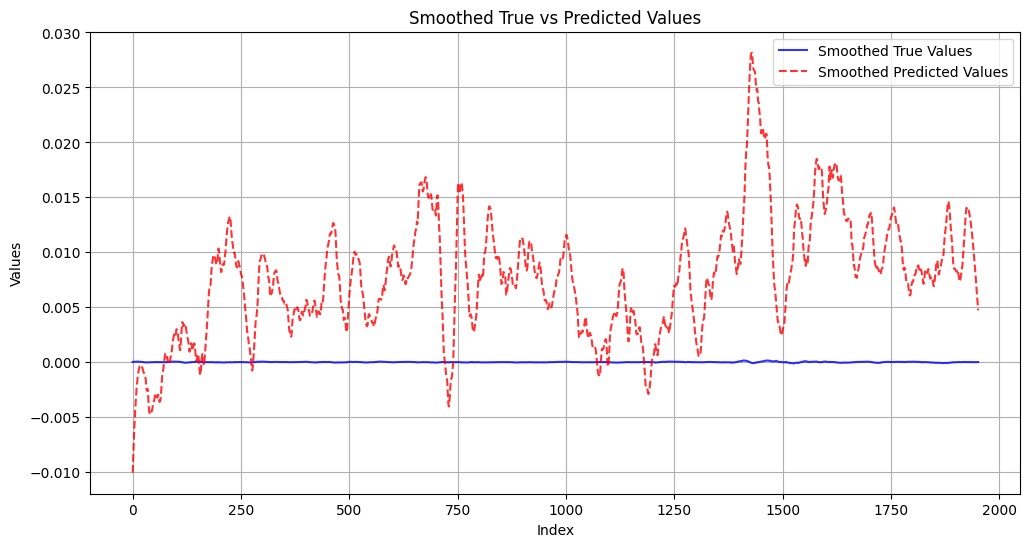

Epoch 2/50, Train RMSE: 0.015741, Val RMSE: 0.005618, Val MAPE: 240366.72%


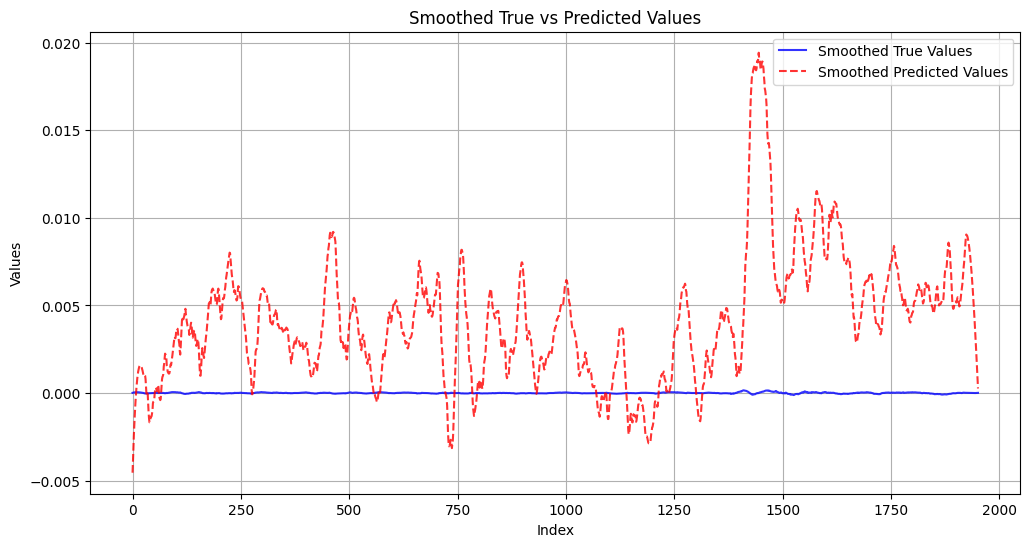

Epoch 3/50, Train RMSE: 0.010991, Val RMSE: 0.006828, Val MAPE: 356710.09%


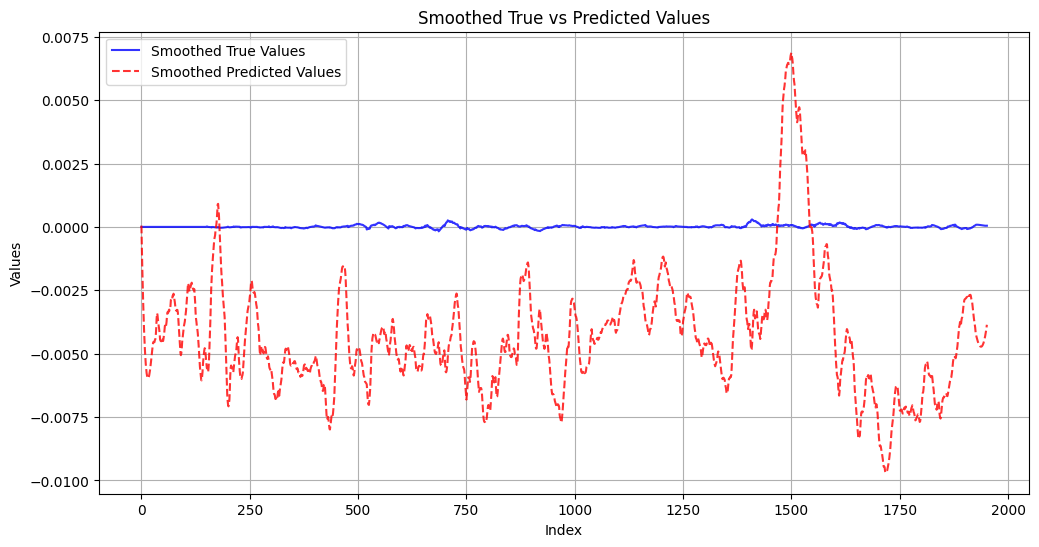

Epoch 4/50, Train RMSE: 0.008427, Val RMSE: 0.007675, Val MAPE: 372604.75%


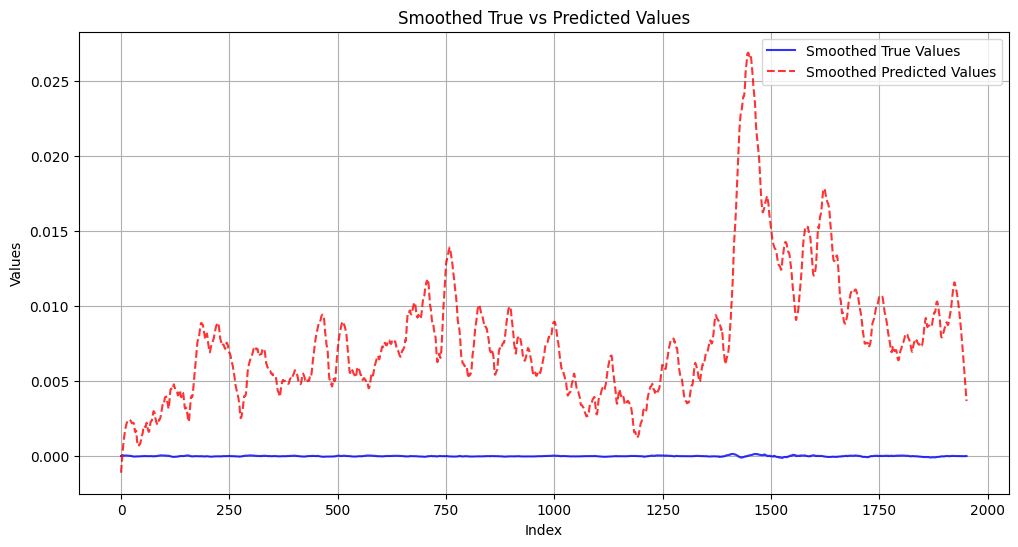

Epoch 5/50, Train RMSE: 0.006719, Val RMSE: 0.008116, Val MAPE: 386242.91%


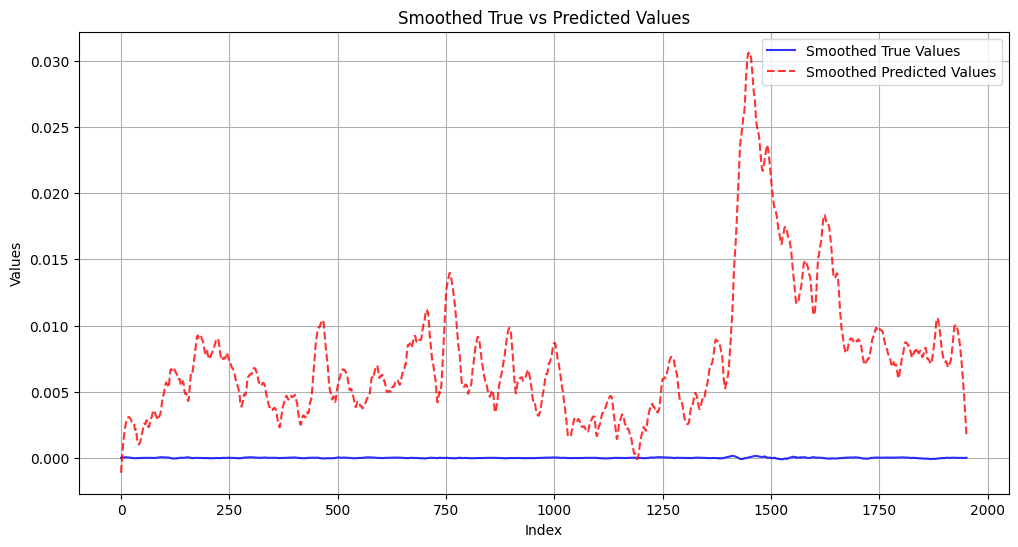

Epoch 6/50, Train RMSE: 0.005650, Val RMSE: 0.004503, Val MAPE: 210647.62%


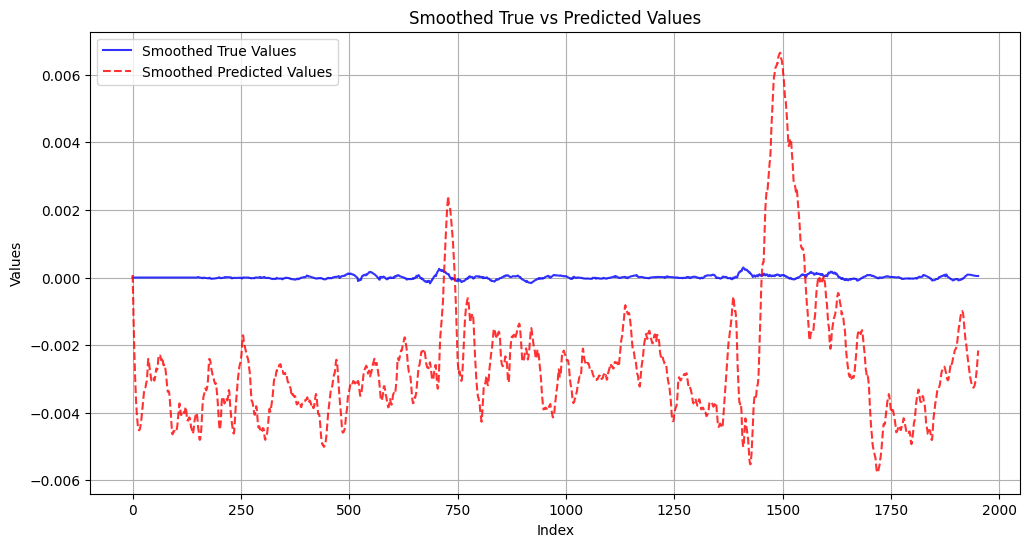

Epoch 7/50, Train RMSE: 0.004726, Val RMSE: 0.004011, Val MAPE: 151240.30%


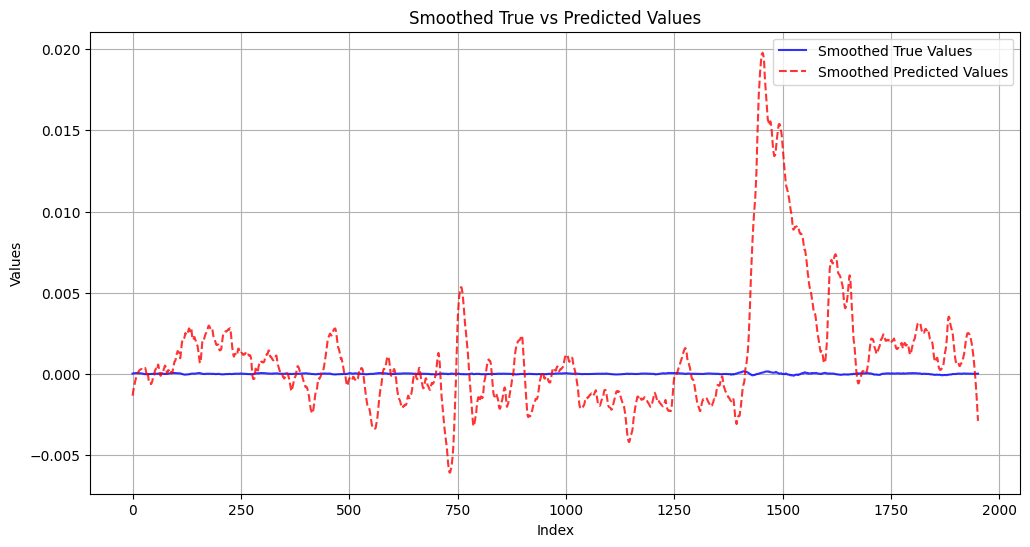

Epoch 8/50, Train RMSE: 0.004291, Val RMSE: 0.004799, Val MAPE: 188479.27%


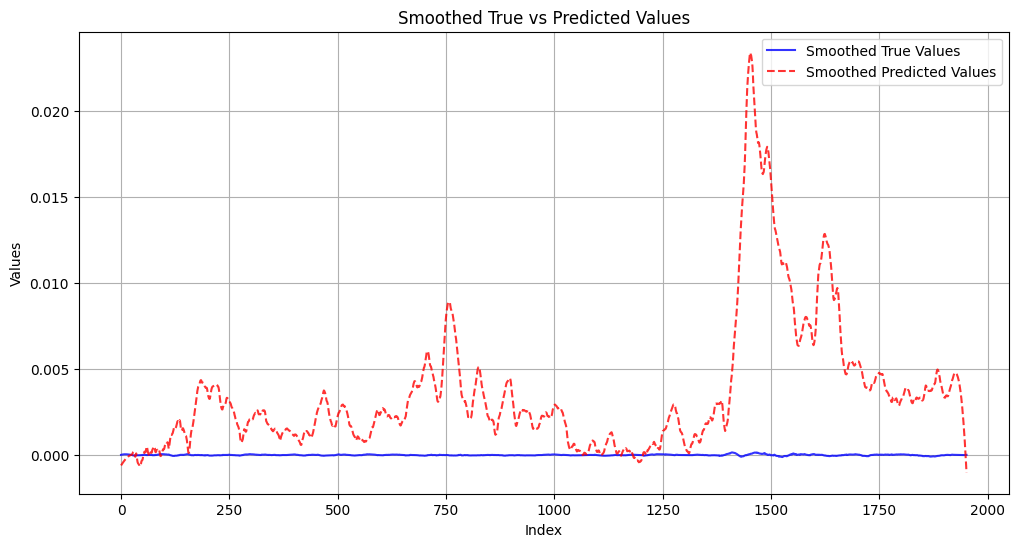

Epoch 9/50, Train RMSE: 0.004077, Val RMSE: 0.003720, Val MAPE: 122989.34%


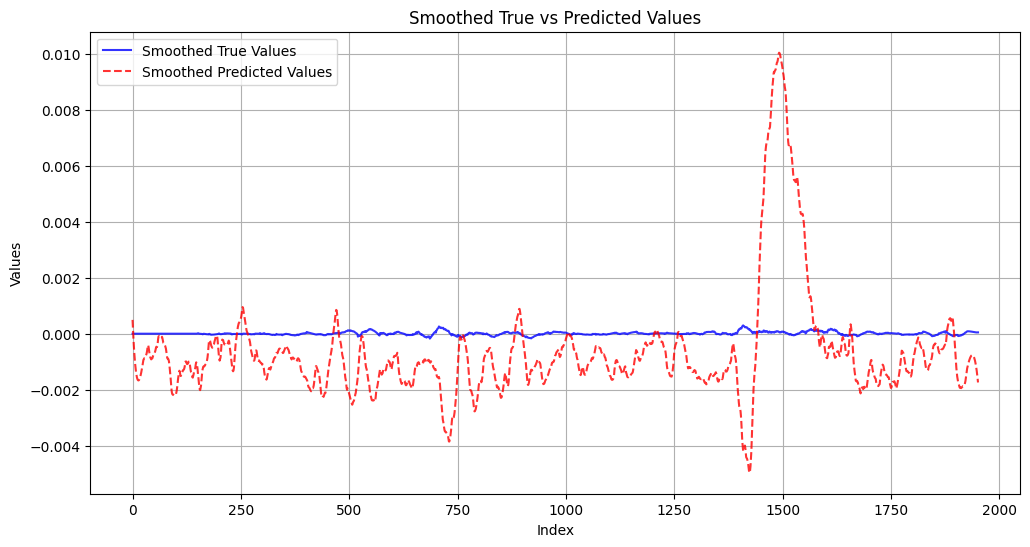

Epoch 10/50, Train RMSE: 0.003778, Val RMSE: 0.004331, Val MAPE: 142342.55%


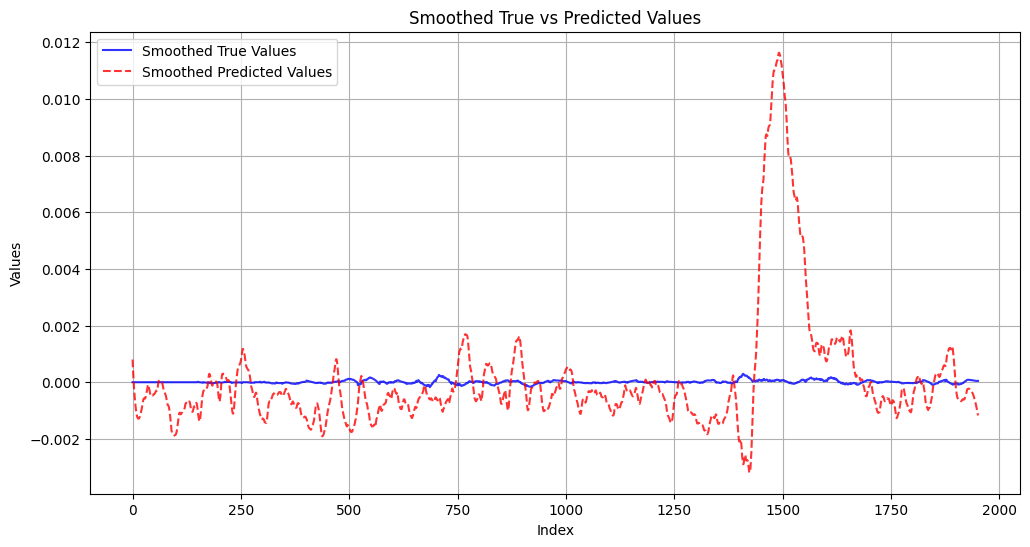

Epoch 11/50, Train RMSE: 0.003399, Val RMSE: 0.004414, Val MAPE: 147283.14%


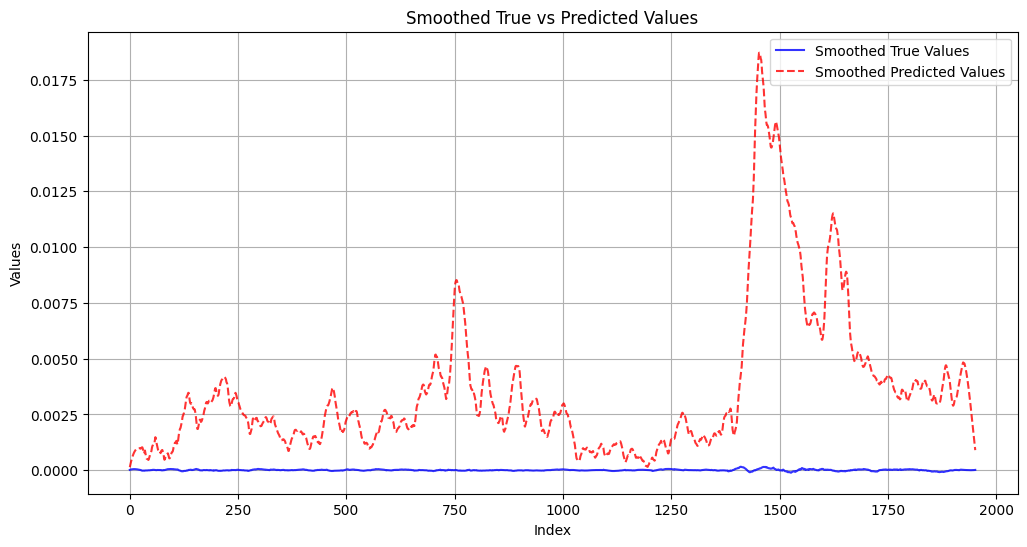

Epoch 12/50, Train RMSE: 0.003522, Val RMSE: 0.005760, Val MAPE: 218976.61%


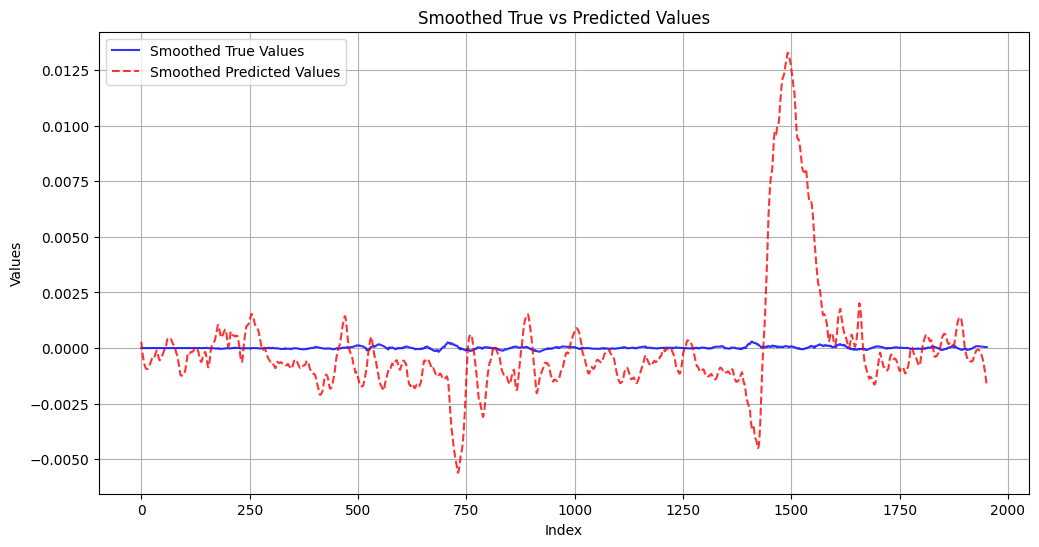

KeyboardInterrupt: 

In [30]:

train_dataset = TimeSeriesDataset(df=df_train, target_var="log_return", cat_features=['currency_pair'], seq_length=10)
test_dataset = TimeSeriesDataset(df=df_test, target_var="log_return", cat_features=['currency_pair'], seq_length=10)

input_features = train_dataset.num_features
num_currency_pairs = train_dataset.num_currency_pairs

train_model(
train_dataset,
test_dataset,
input_features,
num_currency_pairs,
hidden_size=128,
num_layers=2,
dropout=0.2,
initial_lr=1e-4,
min_lr=1e-5,
factor=0.5,
patience=10, 
batch_size=32,
num_epochs=50,
log_dir="./logs",
)